[View in Colaboratory](https://colab.research.google.com/github/aseria/mlcc/blob/test/feature_crosses/feature_crosses.ipynb)

#### Copyright 2017 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

 # 특성 교차

 **학습 목표:**
  * 합성 특성을 추가하여 선형 회귀 모델을 개선한다(이전 실습에서 계속 진행)
  * 입력 함수를 사용하여 `DataFrame` 개체를 `Tensors`로 변환하고 `fit()` 및 `predict()` 작업에서 입력 함수를 호출한다
  * 모델 학습에 FTRL 최적화 알고리즘을 사용한다
  * 원-핫 인코딩, 비닝, 특성 교차를 통해 새 합성 특성을 만든다

 ## 설정

 우선 이전 실습과 마찬가지로 입력을 정의하고 데이터 로딩 코드를 만들겠습니다.

In [0]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://dl.google.com/mlcc/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

In [0]:
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] /
    california_housing_dataframe["population"])
  return processed_features

def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["median_house_value"] = (
    california_housing_dataframe["median_house_value"] / 1000.0)
  return output_targets

In [26]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.7,2669.1,543.8,1441.5,505.5,3.9,2.0
std,2.1,2.0,12.6,2246.6,431.2,1151.7,393.4,1.9,1.2
min,32.5,-124.3,1.0,2.0,1.0,3.0,1.0,0.5,0.1
25%,33.9,-121.8,18.0,1457.0,295.0,788.0,281.0,2.6,1.5
50%,34.3,-118.5,29.0,2129.0,435.0,1170.0,410.0,3.5,1.9
75%,37.7,-118.0,37.0,3173.2,654.0,1741.0,608.0,4.8,2.3
max,42.0,-114.3,52.0,37937.0,6445.0,28566.0,6082.0,15.0,55.2


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.5,28.4,2582.6,528.9,1400.9,490.8,3.9,2.0
std,2.2,2.0,12.5,2009.8,397.1,1138.3,362.2,1.9,1.0
min,32.5,-124.3,2.0,15.0,3.0,11.0,3.0,0.5,0.0
25%,33.9,-121.7,18.0,1471.0,300.0,794.8,284.0,2.6,1.5
50%,34.2,-118.5,28.0,2120.5,431.5,1161.0,406.0,3.5,1.9
75%,37.7,-118.0,37.0,3081.2,638.0,1686.2,596.2,4.8,2.3
max,41.9,-114.5,52.0,30401.0,4957.0,35682.0,4769.0,15.0,26.5


Training targets summary:


,median_house_value
count,12000.0
mean,207.9
std,116.2
min,15.0
25%,119.8
50%,180.6
75%,265.9
max,500.0


Validation targets summary:


,median_house_value
count,5000.0
mean,206.0
std,115.5
min,15.0
25%,118.8
50%,179.4
75%,262.5
max,500.0


In [0]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

 ## FTRL 최적화 알고리즘

고차원 선형 모델에서는 경사 기반 최적화의 일종인 FTRL이 유용합니다. 이 알고리즘의 장점은 여러 가지 계수의 학습률을 서로 다르게 조정한다는 것이며, 이 방법은 일부 특성이 0이 아닌 값을 거의 취하지 않는 경우에 유용할 수 있으며 L1 정규화와도 잘 조화됩니다. [FtrlOptimizer](https://www.tensorflow.org/api_docs/python/tf/train/FtrlOptimizer)를 사용하여 FTRL을 적용할 수 있습니다.

In [0]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    feature_columns,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    feature_columns: A `set` specifying the input feature columns to use.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods

  # Create a linear regressor object.
  my_optimizer = tf.train.FtrlOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )
  
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  
  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  return linear_regressor

Training model...
RMSE (on training data):
  period 00 : 171.32
  period 01 : 131.47
  period 02 : 132.61
  period 03 : 119.20
  period 04 : 145.07
  period 05 : 139.04
  period 06 : 145.11
  period 07 : 141.37
  period 08 : 129.35
  period 09 : 140.51
Model training finished.


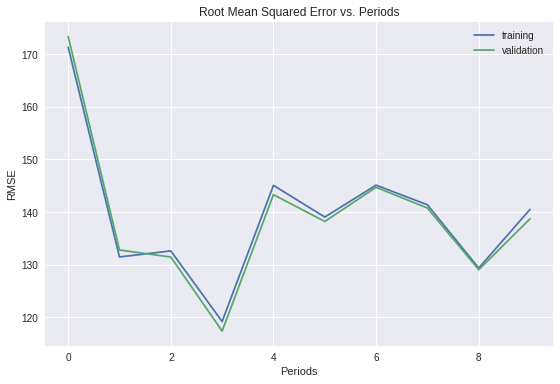

In [8]:
_ = train_model(
    learning_rate=1.0,
    steps=500,
    batch_size=100,
    feature_columns=construct_feature_columns(training_examples),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

 ## 불연속 특성에 대한 원-핫 인코딩

문자열, 열거형, 정수 등의 불연속 특성은 일반적으로 로지스틱 회귀 모델을 학습하기 전에 이진 특성 패밀리로 변환됩니다.

예를 들어 값으로 `0`, `1`, `2`만 취할 수 있는 합성 특성을 만들었으며 몇 개의 학습 포인트가 있다고 가정해 보겠습니다.

| # | feature_value |
|---|---------------|
| 0 |             2 |
| 1 |             0 |
| 2 |             1 |

가능한 각 범주 값에 대해 **실수값**으로 새 **이진** 특성을 만듭니다. 이 특성은 2가지 값만 취할 수 있는데, 예에 해당 값이 포함되었으면 1.0이고 그렇지 않으면 0.0입니다. 위 예제에서는 범주형 특성을 3개의 특성으로 변환하므로 이제 학습 포인트는 다음과 같습니다.

| # | feature_value_0 | feature_value_1 | feature_value_2 |
|---|-----------------|-----------------|-----------------|
| 0 |             0.0 |             0.0 |             1.0 |
| 1 |             1.0 |             0.0 |             0.0 |
| 2 |             0.0 |             1.0 |             0.0 |

 ## 버킷화(비닝) 특성

버킷화를 비닝이라고도 합니다.

예를 들어 `population`을 다음과 같이 3가지로 버킷화할 수 있습니다.
- `bucket_0` (`< 5000`): 인구가 적은 지역에 해당
- `bucket_1` (`5000 - 25000`): 인구가 중간 정도인 지역에 해당
- `bucket_2` (`> 25000`): 인구가 많은 지역에 해당

이러한 버킷 정의로 다음과 같은 `population` 벡터를 변환할 수 있습니다.

    [[10001], [42004], [2500], [18000]]

버킷화 특성 벡터는 다음과 같습니다.

    [[1], [2], [0], [1]]

특성 값은 이제 버킷 색인입니다. 이러한 색인은 불연속 특성으로 간주됩니다. 이러한 특성은 위와 같이 원-핫 표현으로 변환되는 것이 일반적이지만 이 과정은 투명하게 이루어집니다.

버킷화 특성에 대한 특성 열을 정의하려면 `numeric_column`을 사용하는 대신 [`bucketized_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column/bucketized_column)을 사용합니다. 이 특성 열은 입력으로 취한 숫자 열을 `boundardies` 인수에 지정된 버킷 경계를 사용하여 버킷화 특성으로 변환합니다. 다음 코드에서는 `households` 및 `longitude`에 대한 버킷화 특성 열을 정의합니다. `get_quantile_based_boundaries` 함수는 분위를 기준으로 경계를 계산하므로 각 버킷은 동일한 수의 요소를 포함합니다.

In [0]:
def get_quantile_based_boundaries(feature_values, num_buckets):
  boundaries = np.arange(1.0, num_buckets) / num_buckets
  quantiles = feature_values.quantile(boundaries)
  return [quantiles[q] for q in quantiles.keys()]

# Divide households into 7 buckets.
households = tf.feature_column.numeric_column("households")
bucketized_households = tf.feature_column.bucketized_column(
  households, boundaries=get_quantile_based_boundaries(
    california_housing_dataframe["households"], 7))

# Divide longitude into 10 buckets.
longitude = tf.feature_column.numeric_column("longitude")
bucketized_longitude = tf.feature_column.bucketized_column(
  longitude, boundaries=get_quantile_based_boundaries(
    california_housing_dataframe["longitude"], 10))

In [30]:
get_quantile_based_boundaries(california_housing_dataframe["households"], 7) # 7개로 나누었을때 경계값 계산하기.
bucketized_households

_BucketizedColumn(source_column=_NumericColumn(key='households', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(220.0, 300.0, 371.0, 451.0, 567.0, 769.0))

 ## 작업 1: 버킷화 특성 열로 모델 학습
**예의 모든 실수값 확률을 버킷화하고 모델을 학습시킨 후 결과가 개선되는지 확인합니다.**

이전 코드 블록에서는 두 개의 실수값 열(`households` 및 `longitude`)을 버킷화 특성 열로 변환했습니다. 이번에 수행할 작업은 나머지 열을 버킷화한 후 코드를 실행하여 모델을 학습시키는 것입니다. 다양한 휴리스틱으로 버킷의 범위를 정할 수 있습니다. 이 실습에서는 분위 기반 방식을 사용하여 각 버킷에 동일한 수의 예가 포함되도록 버킷 경계를 선택합니다.

In [0]:
def construct_feature_columns():
  """Construct the TensorFlow Feature Columns.

  Returns:
    A set of feature columns
  """ 
  households = tf.feature_column.numeric_column("households")
  longitude = tf.feature_column.numeric_column("longitude")
  latitude = tf.feature_column.numeric_column("latitude")
  housing_median_age = tf.feature_column.numeric_column("housing_median_age")
  median_income = tf.feature_column.numeric_column("median_income")
  rooms_per_person = tf.feature_column.numeric_column("rooms_per_person")
  
  # Divide households into 7 buckets.
  bucketized_households = tf.feature_column.bucketized_column(
    households, boundaries=get_quantile_based_boundaries(
      training_examples["households"], 7))

  # Divide longitude into 10 buckets.
  bucketized_longitude = tf.feature_column.bucketized_column(
    longitude, boundaries=get_quantile_based_boundaries(
      training_examples["longitude"], 10))

  #
  # YOUR CODE HERE: bucketize the following columns, following the example above:
  #
  # 10 buckets
  bucketized_latitude = tf.feature_column.bucketized_column(
    latitude, boundaries=get_quantile_based_boundaries(
      california_housing_dataframe["latitude"], 10))
  # housing median age 5 buckets
  bucketized_housing_median_age = tf.feature_column.bucketized_column(
    housing_median_age, boundaries=get_quantile_based_boundaries(
      training_examples["housing_median_age"], 5))
  
  bucketized_median_income = tf.feature_column.bucketized_column(
    median_income, boundaries=get_quantile_based_boundaries(
      training_examples["median_income"], 10))
  
  bucketized_rooms_per_person = tf.feature_column.bucketized_column(
    rooms_per_person, boundaries=get_quantile_based_boundaries(
      training_examples["rooms_per_person"], 10))
  
  feature_columns = set([
    bucketized_longitude,
    bucketized_latitude,
    bucketized_housing_median_age,
    bucketized_households,
    bucketized_median_income,
    bucketized_rooms_per_person])
  
  return feature_columns


Training model...
RMSE (on training data):
  period 00 : 170.57
  period 01 : 144.03
  period 02 : 127.33
  period 03 : 115.94
  period 04 : 107.84
  period 05 : 101.84
  period 06 : 97.29
  period 07 : 93.71
  period 08 : 90.90
  period 09 : 88.48
Model training finished.


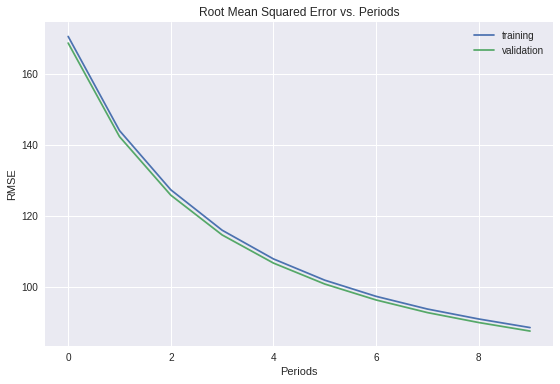

In [36]:
_ = train_model(
    learning_rate=1.0,
    steps=500,
    batch_size=100,
    feature_columns=construct_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

 ### 해결 방법

해결 방법을 보려면 아래를 클릭하세요.

 사용할 버킷 수를 어떠한 기준으로 결정하는지 궁금할 수 있습니다. 물론 데이터 자체와는 무관합니다. 여기에서는 모델이 너무 커지지 않는 선에서 임의로 값을 선택했습니다.

In [0]:
def construct_feature_columns():
  """Construct the TensorFlow Feature Columns.

  Returns:
    A set of feature columns
  """ 
  households = tf.feature_column.numeric_column("households")
  longitude = tf.feature_column.numeric_column("longitude")
  latitude = tf.feature_column.numeric_column("latitude")
  housing_median_age = tf.feature_column.numeric_column("housing_median_age")
  median_income = tf.feature_column.numeric_column("median_income")
  rooms_per_person = tf.feature_column.numeric_column("rooms_per_person")
  
  # Divide households into 7 buckets.
  bucketized_households = tf.feature_column.bucketized_column(
    households, boundaries=get_quantile_based_boundaries(
      training_examples["households"], 7))

  # Divide longitude into 10 buckets.
  bucketized_longitude = tf.feature_column.bucketized_column(
    longitude, boundaries=get_quantile_based_boundaries(
      training_examples["longitude"], 10))
  
  # Divide latitude into 10 buckets.
  bucketized_latitude = tf.feature_column.bucketized_column(
    latitude, boundaries=get_quantile_based_boundaries(
      training_examples["latitude"], 10))

  # Divide housing_median_age into 7 buckets.
  bucketized_housing_median_age = tf.feature_column.bucketized_column(
    housing_median_age, boundaries=get_quantile_based_boundaries(
      training_examples["housing_median_age"], 7))
  
  # Divide median_income into 7 buckets.
  bucketized_median_income = tf.feature_column.bucketized_column(
    median_income, boundaries=get_quantile_based_boundaries(
      training_examples["median_income"], 7))
  
  # Divide rooms_per_person into 7 buckets.
  bucketized_rooms_per_person = tf.feature_column.bucketized_column(
    rooms_per_person, boundaries=get_quantile_based_boundaries(
      training_examples["rooms_per_person"], 7))
  
  feature_columns = set([
    bucketized_longitude,
    bucketized_latitude,
    bucketized_housing_median_age,
    bucketized_households,
    bucketized_median_income,
    bucketized_rooms_per_person])
  
  return feature_columns

In [0]:
_ = train_model(
    learning_rate=1.0,
    steps=500,
    batch_size=100,
    feature_columns=construct_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

 ## 특성 교차

둘 이상의 특성을 교차하는 것은 선형 모델을 사용하여 비선형 관계를 학습하는 효과적인 방법입니다. 이 문제에서 `latitude` 특성만 학습에 사용하면 모델은 특정 위도에 있는 지역, 버킷화를 거쳤으므로 정확히는 특성 위도 범위에 포함된 지역이 다른 지역보다 집값이 비쌀 가능성이 높다는 사실을 학습할 수 있습니다. 그러나 `longitude`와 `latitude`를 교차하면 이 교차 특성은 잘 정의된 지역을 나타냅니다. 모델에서 위도 및 경도 범위에 포함된 특정 지역이 다른 지역보다 집값이 비쌀 가능성이 높다는 사실을 학습하면 두 특성을 개별적으로 고려할 때보다 강한 신호가 됩니다.

현재 특성 열 API는 불연속 특성에 대해서만 교차를 지원합니다. `latitude` 또는 `longitude` 등의 두 연속 특성을 교차하려면 버킷화를 거쳐야 합니다.

`latitude` 특성과 `longitude` 특성을 교차할 때 longitude`를 `2`개 버킷으로, `latitude`를 `3`개 버킷으로 만들었다면 실제로 6개의 교차 이진 특성을 얻게 됩니다. 모델을 학습시킬 때 이러한 각 특성에 별도의 가중치가 부여됩니다.

 ## 작업 2: 특성 교차를 사용하여 모델 학습

**모델에 `longitude`와 `latitude`의 특성 교차를 추가하고 학습시켜 결과가 개선되는지 여부를 판단합니다.**

TensorFlow API 문서에서 [`crossed_column()`](https://www.tensorflow.org/api_docs/python/tf/feature_column/crossed_column)을 참조하여 교차 특성 열을 작성하세요. `hash_bucket_size`는 `1000`으로 지정합니다.

In [0]:
def construct_feature_columns():
  """Construct the TensorFlow Feature Columns.

  Returns:
    A set of feature columns
  """ 
  households = tf.feature_column.numeric_column("households")
  longitude = tf.feature_column.numeric_column("longitude")
  latitude = tf.feature_column.numeric_column("latitude")
  housing_median_age = tf.feature_column.numeric_column("housing_median_age")
  median_income = tf.feature_column.numeric_column("median_income")
  rooms_per_person = tf.feature_column.numeric_column("rooms_per_person")
  
  # Divide households into 7 buckets.
  bucketized_households = tf.feature_column.bucketized_column(
    households, boundaries=get_quantile_based_boundaries(
      training_examples["households"], 7))

  # Divide longitude into 10 buckets.
  bucketized_longitude = tf.feature_column.bucketized_column(
    longitude, boundaries=get_quantile_based_boundaries(
      training_examples["longitude"], 10))
  
  # Divide latitude into 10 buckets.
  bucketized_latitude = tf.feature_column.bucketized_column(
    latitude, boundaries=get_quantile_based_boundaries(
      training_examples["latitude"], 10))

  # Divide housing_median_age into 7 buckets.
  bucketized_housing_median_age = tf.feature_column.bucketized_column(
    housing_median_age, boundaries=get_quantile_based_boundaries(
      training_examples["housing_median_age"], 7))
  
  # Divide median_income into 7 buckets.
  bucketized_median_income = tf.feature_column.bucketized_column(
    median_income, boundaries=get_quantile_based_boundaries(
      training_examples["median_income"], 7))
  
  # Divide rooms_per_person into 7 buckets.
  bucketized_rooms_per_person = tf.feature_column.bucketized_column(
    rooms_per_person, boundaries=get_quantile_based_boundaries(
      training_examples["rooms_per_person"], 7))
  
  # YOUR CODE HERE: Make a feature column for the long_x_lat feature cross
  long_x_lat = tf.feature_column.crossed_column([bucketized_longitude, bucketized_latitude], 1000)
  
  feature_columns = set([
    bucketized_longitude,
    bucketized_latitude,
    bucketized_housing_median_age,
    bucketized_households,
    bucketized_median_income,
    bucketized_rooms_per_person,
    long_x_lat])
  
  return feature_columns

Training model...
RMSE (on training data):
  period 00 : 164.10
  period 01 : 135.82
  period 02 : 118.87
  period 03 : 107.48
  period 04 : 99.48
  period 05 : 93.65
  period 06 : 89.12
  period 07 : 85.61
  period 08 : 82.80
  period 09 : 80.41
Model training finished.


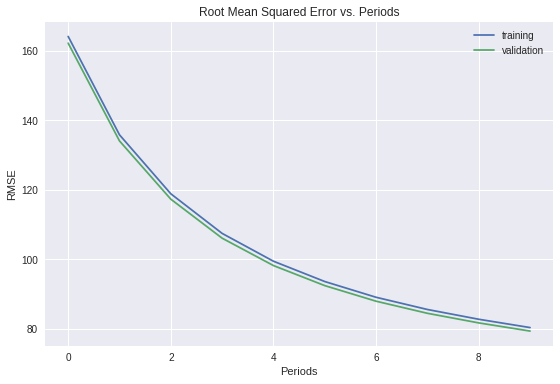

In [42]:
_ = train_model(
    learning_rate=1.0,
    steps=500,
    batch_size=100,
    feature_columns=construct_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

 ### 해결 방법

해결 방법을 보려면 아래를 클릭하세요.

In [0]:
def construct_feature_columns():
  """Construct the TensorFlow Feature Columns.

  Returns:
    A set of feature columns
  """ 
  households = tf.feature_column.numeric_column("households")
  longitude = tf.feature_column.numeric_column("longitude")
  latitude = tf.feature_column.numeric_column("latitude")
  housing_median_age = tf.feature_column.numeric_column("housing_median_age")
  median_income = tf.feature_column.numeric_column("median_income")
  rooms_per_person = tf.feature_column.numeric_column("rooms_per_person")
  
  # Divide households into 7 buckets.
  bucketized_households = tf.feature_column.bucketized_column(
    households, boundaries=get_quantile_based_boundaries(
      training_examples["households"], 7))

  # Divide longitude into 10 buckets.
  bucketized_longitude = tf.feature_column.bucketized_column(
    longitude, boundaries=get_quantile_based_boundaries(
      training_examples["longitude"], 10))
  
  # Divide latitude into 10 buckets.
  bucketized_latitude = tf.feature_column.bucketized_column(
    latitude, boundaries=get_quantile_based_boundaries(
      training_examples["latitude"], 10))

  # Divide housing_median_age into 7 buckets.
  bucketized_housing_median_age = tf.feature_column.bucketized_column(
    housing_median_age, boundaries=get_quantile_based_boundaries(
      training_examples["housing_median_age"], 7))
  
  # Divide median_income into 7 buckets.
  bucketized_median_income = tf.feature_column.bucketized_column(
    median_income, boundaries=get_quantile_based_boundaries(
      training_examples["median_income"], 7))
  
  # Divide rooms_per_person into 7 buckets.
  bucketized_rooms_per_person = tf.feature_column.bucketized_column(
    rooms_per_person, boundaries=get_quantile_based_boundaries(
      training_examples["rooms_per_person"], 7))
  
  # YOUR CODE HERE: Make a feature column for the long_x_lat feature cross
  long_x_lat = tf.feature_column.crossed_column(
  set([bucketized_longitude, bucketized_latitude]), hash_bucket_size=1000) 
  
  feature_columns = set([
    bucketized_longitude,
    bucketized_latitude,
    bucketized_housing_median_age,
    bucketized_households,
    bucketized_median_income,
    bucketized_rooms_per_person,
    long_x_lat])
  
  return feature_columns

Training model...
RMSE (on training data):
  period 00 : 164.10
  period 01 : 135.89
  period 02 : 118.68
  period 03 : 107.21
  period 04 : 99.05
  period 05 : 93.09
  period 06 : 88.53
  period 07 : 84.86
  period 08 : 81.92
  period 09 : 79.42
Model training finished.


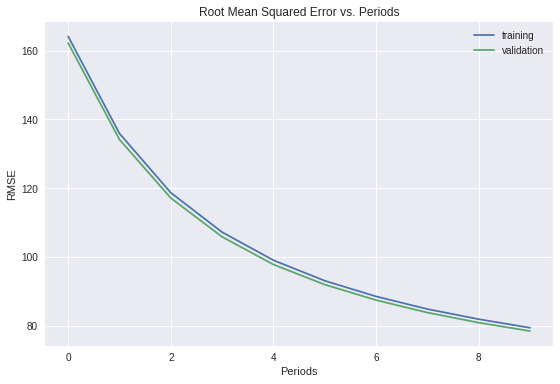

In [44]:
_ = train_model(
    learning_rate=1.0,
    steps=500,
    batch_size=100,
    feature_columns=construct_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

 ## 선택 과제: 더 많은 합성 특성 실험

지금까지는 단순한 버킷화 열 및 특성 교차를 시험했지만, 이외에도 수많은 조합을 통해 결과를 개선할 수 있습니다. 예를 들어 여러 열을 교차할 수 있습니다. 버킷 수에 변화를 주면 어떻게 될까요? 다른 합성 특성을 생각해 볼 수 있을까요? 모델을 개선하는 효과가 있나요?